In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from deepface import DeepFace
import psycopg2
from psycopg2 import sql

In [16]:
# Database connection parameters
db_params = {
    'dbname': 'College automated reporting system',
    'user': 'postgres',
    'password': 'Automated@12',
    'host': 'localhost',
    'port': 5432
}

# Connect to the PostgreSQL database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

In [3]:
def preprocess_image(image):
    if image is not None and image.size != 0:
        image = cv2.resize(image, (224, 224))  # VGG-Face expects 224x224 images
        image = image / 255.0  # Normalize
        return image
    else:
        return None

In [4]:
def load_images_from_directory(base_dir):
    images = []
    labels = []
    for person_name in os.listdir(base_dir):
        person_dir = os.path.join(base_dir, person_name)
        for filename in os.listdir(person_dir):
            img_path = os.path.join(person_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(person_name)
    return images, labels

In [5]:
def get_face_embedding(image):
    if image is not None:
        return DeepFace.represent(img_path=image, model_name="VGG-Face", enforce_detection=False)[0]["embedding"]
    else:
        return None

In [6]:
def recognize_face(test_embedding, known_face_encodings, known_face_names):
    distances = [np.linalg.norm(test_embedding - known_face_encoding) for known_face_encoding in known_face_encodings]
    best_match_index = np.argmin(distances)
    if distances[best_match_index] < 0.6:
        return known_face_names[best_match_index]
    else:
        return "Unknown"

In [7]:
def extract_subject_and_date_from_filename(filename):
    parts = filename.split('_')
    subject = parts[0]
    date = parts[1].split('.')[0]
    return subject, date


In [8]:
def test_on_mono_faces(test_directory, known_face_encodings, known_face_names):
    for filename in os.listdir(test_directory):
        test_image_path = os.path.join(test_directory, filename)
        test_image = cv2.imread(test_image_path)
        test_image_preprocessed = preprocess_image(test_image)
        if test_image_preprocessed is not None:
            test_embedding = get_face_embedding(test_image_preprocessed)
            if test_embedding is not None:
                name = recognize_face(test_embedding, known_face_encodings, known_face_names)
                plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
                plt.title(f"Recognized person: {name}")
                plt.axis('off')
                plt.show()

In [9]:
def test_on_multi_faces(test_directory, known_face_encodings, known_face_names):
    for filename in os.listdir(test_directory):
        test_image_path = os.path.join(test_directory, filename)
        test_image = cv2.imread(test_image_path)
        
        faces = DeepFace.extract_faces(img_path=test_image_path, detector_backend='opencv', enforce_detection=False)
        
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        
        recognized_names = []
        
        for face in faces:
            facial_area = face['facial_area']
            x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
            face_image = test_image[y:y+h, x:x+w]
            face_preprocessed = preprocess_image(face_image)
            if face_preprocessed is not None:
                face_embedding = get_face_embedding(face_preprocessed)
                if face_embedding is not None:
                    name = recognize_face(face_embedding, known_face_encodings, known_face_names)
                    if name != "Unknown":
                        recognized_names.append(name)
                    ax.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
                    plt.text(x, y - 10, name, color='red', fontsize=12, weight='bold')
        
        plt.axis('off')
        plt.show()
        
        subject, date = extract_subject_and_date_from_filename(filename)
        if recognized_names:
            print(f"Students {recognized_names} attended {subject} on {date}")
            mark_attendance(subject, date, recognized_names, filename)

In [10]:
def mark_attendance(subject_name, date, students, image_name):
    subject_id = get_subject_id_by_name(subject_name)
    if subject_id is None:
        print(f"Subject '{subject_name}' not found in the database.")
        return
    for student in students:
        student_id = get_student_id_by_name(student)
        if student_id is None:
            print(f"Student '{student}' not found in the database.")
            continue
        cursor.execute(
            sql.SQL('INSERT INTO "Clg automated"."Attendance" (date, subject_id, student_id, image) VALUES (%s, %s, %s, %s)'),
            [date, subject_id, student_id, image_name]
        )
    conn.commit()

def get_subject_id_by_name(name):
    cursor.execute(sql.SQL('SELECT id FROM "Clg automated"."Subject" WHERE "name" = %s'), [name])
    result = cursor.fetchone()
    return result[0] if result else None

def get_student_id_by_name(name):
    cursor.execute(sql.SQL('SELECT id FROM "Clg automated"."Student" WHERE "Name" = %s'), [name])
    result = cursor.fetchone()
    return result[0] if result else None

In [11]:
# Load training images
training_dir = r'C:\Users\Prathamesh\Desktop\Infosys project\Image directory\1. Training images'
train_images, train_labels = load_images_from_directory(training_dir)

In [12]:
# Preprocess and encode training images
known_face_encodings = []
known_face_names = []
for img, label in zip(train_images, train_labels):
    img_preprocessed = preprocess_image(img)
    if img_preprocessed is not None:
        embedding = get_face_embedding(img_preprocessed)
        if embedding is not None:
            known_face_encodings.append(np.array(embedding))
            known_face_names.append(label)

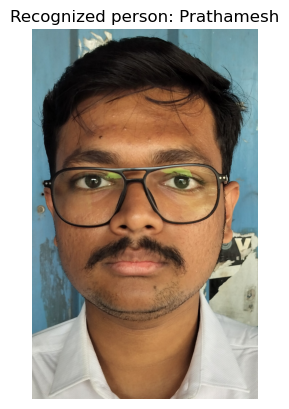

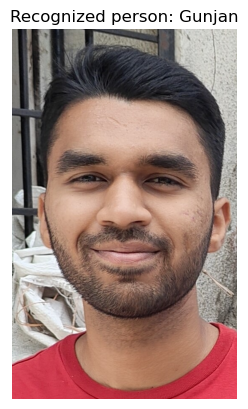

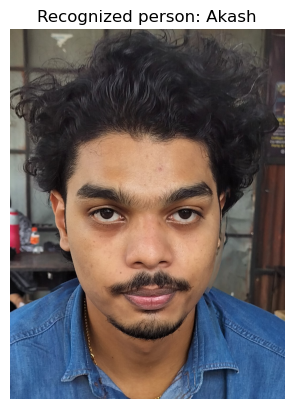

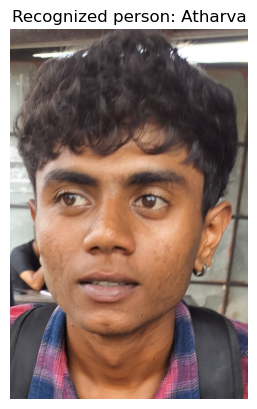

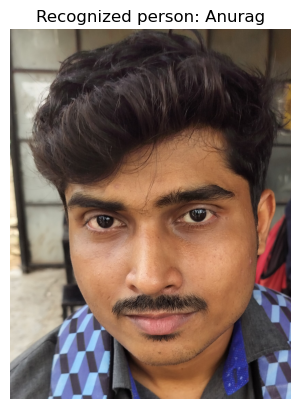

In [13]:
# Test on Mono faces
mono_face_test_directory = r'C:\Users\Prathamesh\Desktop\Infosys project\Image directory\2. Testing images\Mono face'
test_on_mono_faces(mono_face_test_directory, known_face_encodings, known_face_names)

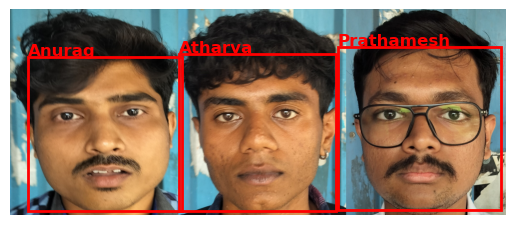

Students ['Anurag', 'Atharva', 'Prathamesh'] attended Artificial Intelligence on 20240627


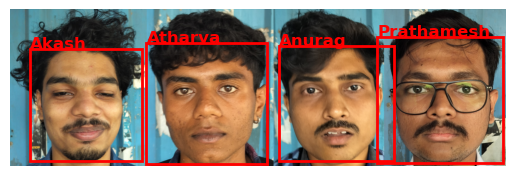

Students ['Akash', 'Atharva', 'Anurag', 'Prathamesh'] attended Data Science on 20240626


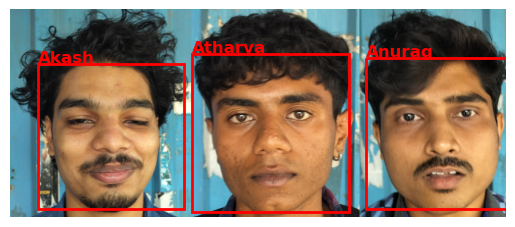

Students ['Akash', 'Atharva', 'Anurag'] attended Data Science on 20240627


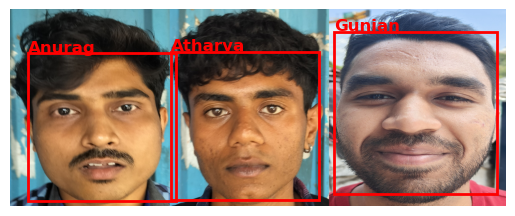

Students ['Anurag', 'Gunjan', 'Atharva'] attended Machine Learning on 20240627


In [17]:
# Test on Multi faces
multi_face_test_directory = r'C:\Users\Prathamesh\Desktop\Infosys project\Image directory\2. Testing images\Multi face'
test_on_multi_faces(multi_face_test_directory, known_face_encodings, known_face_names)

In [15]:
# Close the database connection
cursor.close()
conn.close()